In [38]:
"""Importing required libraries"""
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import seaborn as sns

In [24]:
data = pd.read_csv('../Machine_Learning/KaggleV2-May-2016.csv')
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## I. Data preprocessing

In [25]:
#Renaming Columns
data = data.rename(columns={'PatientId':'patient_id','AppointmentID':'appointment_id','Gender': 'sex', 'ScheduledDay': 'scheduled_day', 'AppointmentDay': 'appointment_day', 
                                    'Age': 'age', 'Neighbourhood': 'neighbourhood', 'Scholarship': 'scholarship', 
                                    'Hipertension': 'hypertension', 'Diabetes': 'diabetic', 'Alcoholism': 'alcoholic', 
                                    'Handcap': 'handicap', 'No-show': 'no_show'})


#binarizing columns
data['no_show'] = data['no_show'].map({'No': 1, 'Yes': 0})
data['sex'] = data['sex'].map({'F': 0, 'M': 1})
data['handicap'] = data['handicap'].apply(lambda x: 2 if x > 2 else x)


#Converting the AppointmentDay and ScheduledDay into a date and time format 
data['scheduled_day'] = pd.to_datetime(data['scheduled_day'], infer_datetime_format=True)
data['appointment_day'] = pd.to_datetime(data['appointment_day'], infer_datetime_format=True)




In [26]:
data.describe()

,patient_id,appointment_id,sex,age,scholarship,hypertension,diabetic,alcoholic,handicap,SMS_received,no_show
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022076,0.321026,0.798067
std,2.560949e+14,7.129575e+04,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.158713,0.466873,0.401444
min,3.921784e+04,5.030230e+06,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.439172e+13,5.725524e+06,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


####  The minimum age shown is -1 and maximum age is 115. Though there are people who are living/lived past the age of 100, it is usually rare and not common. Thus, these values are excluded. 

In [27]:
data.drop(data[data['age'] <= 0].index, inplace=True)
data.drop(data[data['age'] >100].index, inplace=True)

####  A new column is added: neighbourhood_enc. There are around 80 neighbourhoods and it could potentially contribute to the patients not showing up at the doctor(for example: because of distance they had to travel to visit the doctor). LabelEncoder is used to encode neighbourhoods to numbers.

In [28]:
encoder_neighbourhood = LabelEncoder()
data['neighbourhood_enc'] = encoder_neighbourhood.fit_transform(data['neighbourhood'])

#### The next column added was waiting_time. For this, the number of days the patient had to wait to visit the doctor was calculated. There was a negative waiting time, which was due to incorrect entries in the dataset. That is, the ScheduledDay(the day when the appointment was booked) was after AppointmentDay(the day of the appointment). Thus, these values are excluded.

In [29]:
data['waiting_time'] = list(map(lambda x: x.days+1 , data['appointment_day'] - data['scheduled_day']))
data.drop(data[data['waiting_time'] <= -1].index, inplace=True)

####  The next column added was days of week column

In [30]:
data['appointment_dayofWeek'] = data['appointment_day'].map(lambda x: x.dayofweek)

#### To find out the probability of a person not likely to show up for an appointment a "risk score" was calculated:
(no.of times a patient didn't show up / total no. of appointments he/she booked) 

In [31]:
data['no_of_noshows'] = data.groupby('patient_id')[['no_show']].transform('sum')
data['total_appointment'] = data.groupby('patient_id')[['no_show']].transform('count')

data['risk_score'] = data.no_of_noshows / data.total_appointment

## II. Modeling

### Split data into training set and testing set 

In [32]:
#Removing columns that are not necessary for prediction
data.drop(['scheduled_day','appointment_day','neighbourhood','patient_id','appointment_id'], axis=1, inplace=True)


In [33]:
#Splitting the data into training and testing sets.
X = data.drop(['no_show'], axis=1)
y = data['no_show']
X.head()
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Method: Random Forest Classification

In [34]:
clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Calculating Metrics

Mean Accuracy:
0.90248279988
------------------------------------------------
Confusion Matrix:
[[ 4005  1335]
 [ 1273 20131]]
------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

          0       0.76      0.75      0.75      5340
          1       0.94      0.94      0.94     21404

avg / total       0.90      0.90      0.90     26744

------------------------------------------------


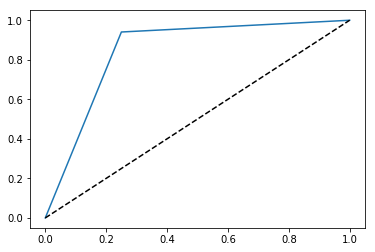

Area under curve (AUC):  0.845262567744


In [39]:
#Performance Check
print("Mean Accuracy:")
print(clf.score(X_test, y_test))
print("------------------------------------------------")

print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("------------------------------------------------")

print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Area Under Curve 
y_score = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))


### Feature Importance: Top 10 features

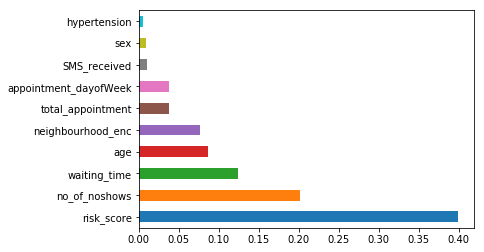

In [37]:
#Plotting feature importance
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh')
plt.show()